# Infant gut metabolites

## Setup
Import required libraries for this notebook.

In [5]:
from waveome.model_search import GPSearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [6]:
metabolite = pd.read_csv("/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/Github example/Breastmilk/infant_metabolite.tsv",
    # 'https://github.com/omicsEye/waveome/blob/main/examples/Breastmilk/infant_metabolite.tsv',
    header=None,sep="\t")
# In this example we rearrange the first row as the column names.
new_column_names = metabolite.iloc[0]
metabolite.columns = new_column_names
metabolite = metabolite.drop([0])
metabolite.reset_index(drop=True, inplace=True)
metadata = pd.read_csv("/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/Github example/Breastmilk/stool_metadata.csv",
    # 'https://github.com/omicsEye/waveome/blob/main/examples/Breastmilk/stool_metadata.csv',
    header=None,sep=",")
new_column_names = metadata.iloc[0]
metadata.columns = new_column_names
metadata = metadata.drop([0])
metadata.reset_index(drop=True, inplace=True)
df = metadata.merge(metabolite, on='X', how='right')
df['X'] = df['X'].str.extract(r'(\d+)').astype(int)
print(df.shape)
# Define mapping dictionary for 'Sex'
sex_mapping = {'Female': 1, 'Male': 0}
# Define mapping dictionary for 'Maternal vs. donor'
maternal_donor_mapping = {'Maternal': 1, 'Donor': 0}
# Define mapping dictionary for 'Diet'
Diet_mapping = {'0_Exclusive_BM': 0, '1_BM_fortified_formula': 1 , '2_Exclusive_donor_BM':2 ,
                '5_MBM_donor_milk':5 , '6_donor_milk_fortified_formula':6 ,
                '7_MBM_DBM_fortified':7}
# Define mapping dictionary for 'Visit_time_point'
Visit_time_point_mapping = {'a': 0, 'b': 3 , 'c':7 ,'d':11}
# Replace values in 'Sex' column
df['Sex'] = df['Sex'].replace(sex_mapping)
# Replace values in 'Maternal vs. donor' column
df['Maternal_vs_donor'] = df['Maternal_vs_donor'].replace(maternal_donor_mapping)
# Replace values in 'Diet' column
df['Diet'] = df['Diet'].replace(Diet_mapping)
# Replace values in 'Visit_time_point' column
df['Visit_time_point'] = df['Visit_time_point'].replace(Visit_time_point_mapping)
# We replace the abundance of non observed metabolites with zero.
df = df.fillna(0)
# Name of the metabolites contain special characters which may cause som problems in saving the outputs with appropriate file names.
new_column_names = {col: col.replace("'", "_").replace(":", "_").replace(",", "_").replace("`", "_").replace("/", "_") for col in df.columns}
df.rename(columns=new_column_names, inplace=True)

(72, 1169)


We need to get sure that all the abundances are numeric and be as `float` type.

In [7]:
columns_to_convert = ['X', 'External_ID', 'Visit_time_point', 'Gestational_age_week', 'Gestational_age_day',
                      'Gestational_age','Birth_weight', 'Age_at_breast_milk_sample', 'Stool_sample_date', 
                      'Age_at_stool_sample']+df.columns[13:].tolist()
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
for column_name in df.columns:
    column_type = df[column_name].dtype
    print(f"Column '{column_name}' is {column_type}")

Column 'X' is int64
Column 'External_ID' is int64
Column 'Visit_time_point' is int64
Column 'Gestational_age_week' is int64
Column 'Gestational_age_day' is int64
Column 'Gestational_age' is int64
Column 'Birth_weight' is float64
Column 'Sex' is int64
Column 'Age_at_breast_milk_sample' is int64
Column 'Maternal_vs_donor' is int64
Column 'Stool_sample_date' is float64
Column 'Age_at_stool_sample' is int64
Column 'Diet' is int64
Column '(14 or 15)-methylpalmitate (a17_0 or i17_0)' is int64
Column '(16 or 17)-methylstearate (a19_0 or i19_0)' is float64
Column '(2 or 3)-decenoate (10_1n7 or n8)' is float64
Column '(N(1) + N(8))-acetylspermidine' is float64
Column '(R)-3-hydroxybutyrylcarnitine' is float64
Column '(S)-3-hydroxybutyrylcarnitine' is float64
Column '(S)-a-amino-omega-caprolactam' is float64
Column '1_-hydroxymidazolam' is float64
Column '1_2_3-benzenetriol sulfate (2)' is float64
Column '1_2-dilinoleoyl-GPC (18_2_18_2)' is float64
Column '1_2-dipalmitoyl-GPC (16_0_16_0)' is flo

We are applying _waveome_ only on those metabolites that we have a predefined number of subjects with at least two time-points. Fir instance, the following cell, returns the name of metaolites which we have at least 5 subjects/individuals with at least two time-points non-zero measurements.

In [8]:
selected_columns = []
for col in df.columns.tolist()[13:]:
    #### Filter the DataFrame to include only rows where the column is nonzero
    nonzero_rows = df[(df[col] != 0) & (df[col].notna())]
    # print(nonzero_rows)
    #### Count the unique 'index' groups with at least 3 nonzero values
    index_counts = nonzero_rows.groupby('X')[col].count()
    # print(index_counts)
    #### Check if there are at least 10 unique 'index' groups with at least 2 nonzero values
    if (index_counts >= 2).sum() >= 5:
        selected_columns.append(col)
# df[selected_columns]= df[selected_columns].fillna(value={"NA": 0})
df = df.fillna(0)
print(len(selected_columns))#1020 metabolites are selected for rurther analysis

1020


If you want to fillow-up with the results, running the following cell is b=not suggested because it may takes hours to run. However, we have saved the output into a `.pkl` file and you can download and load it after this cell.

In [14]:
gps = GPSearch(
       X=df[['X', 'Gestational_age', 'Birth_weight', 'Sex', 'Maternal_vs_donor', 
             'Age_at_stool_sample', 'Diet']].astype(float),
       Y=df[selected_columns].astype(float),
       unit_col='X',
       categorical_vars=['Sex', 'Maternal_vs_donor', 'Diet'],
       outcome_likelihood= 'poisson'
)
gps.run_search(
    random_seed=9102
)
# Save the gps object to a file. Next time you can easily load the outputs without running the whole procedure.
with open('/Users/alireza/DataspellProjects/waveome/examples/Breastmilk/gps_zeromissing_poi_ALL.pkl', 'wb') as f:
    pickle.dump(gps, f)

Here is where you can load the saved outputs.

In [10]:
# Load the gps object from the file
with open('/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/Github example/Breastmilk/gps_zeromissing_poi_ALL.pkl', 'rb') as f:
    loaded_gps = pickle.load(f)

In [19]:
loaded_gps.models["N6-carboxymethyllysine"]

{'models': {'categorical[4]*squared_exponential[5]': {'kernel': <gpflow.kernels.base.Product object at 0x7f8575b82580>
╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Product.kernels[0].variance     │ Parameter │ Softplus    │ Uniform │ False       │ ()      │ float64 │ 1       │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[1].variance     │ Parameter │ Softplus    │ Uniform │ True        │ ()      │ float64 │ 5.00304 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[1].lengthscales │ Parameter │ Softplus    │ Uniform

Based on the above mentione output, 80% of the total variations of 'N6-carboxymethyllysine' are descriped by a squared exponential function of the "infant age" per type of brestmilk host (maternal or donor). The expected marginal mean for two different subjects (subject "1" and "5") are demonstrated below.

<Axes: xlabel='Age_at_stool_sample'>

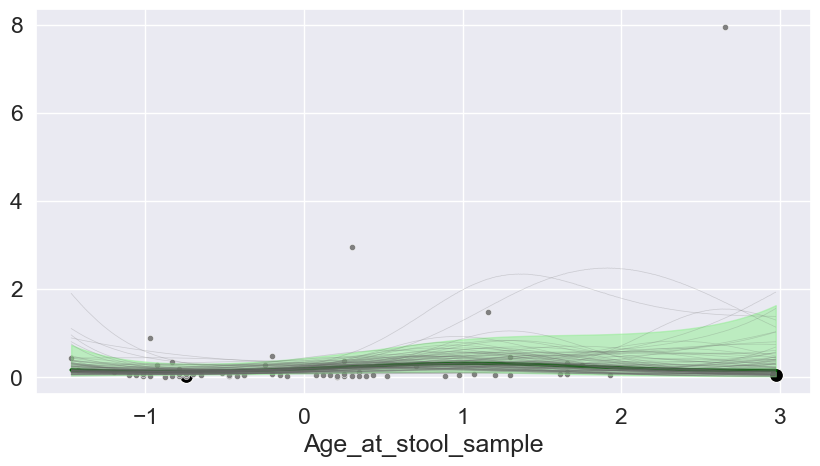

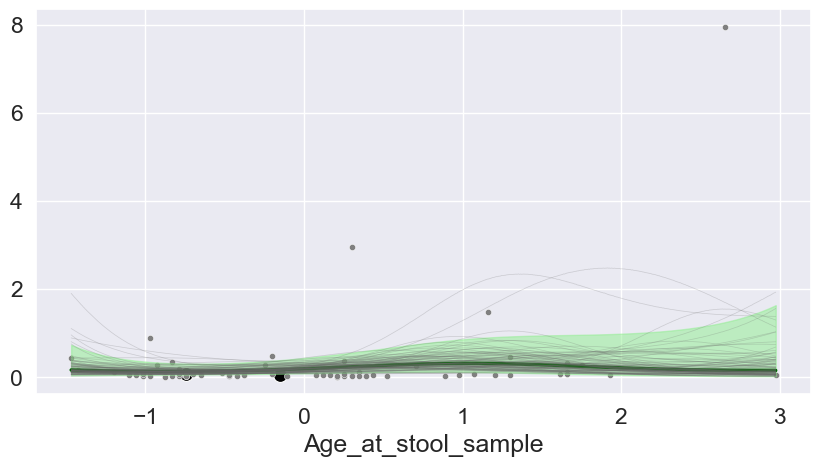

In [28]:
loaded_gps.plot_marginal(
    out_label='N6-carboxymethyllysine', 
    x_axis_label='Age_at_stool_sample',
    unit_label=1
)
loaded_gps.plot_marginal(
    out_label='N6-carboxymethyllysine', 
    x_axis_label='Age_at_stool_sample',
    unit_label=5
)

The `gps` object is loaded and named 'loaded_gps'. In the following cell some visualizations features are presented to manage and saved heatmap plot. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


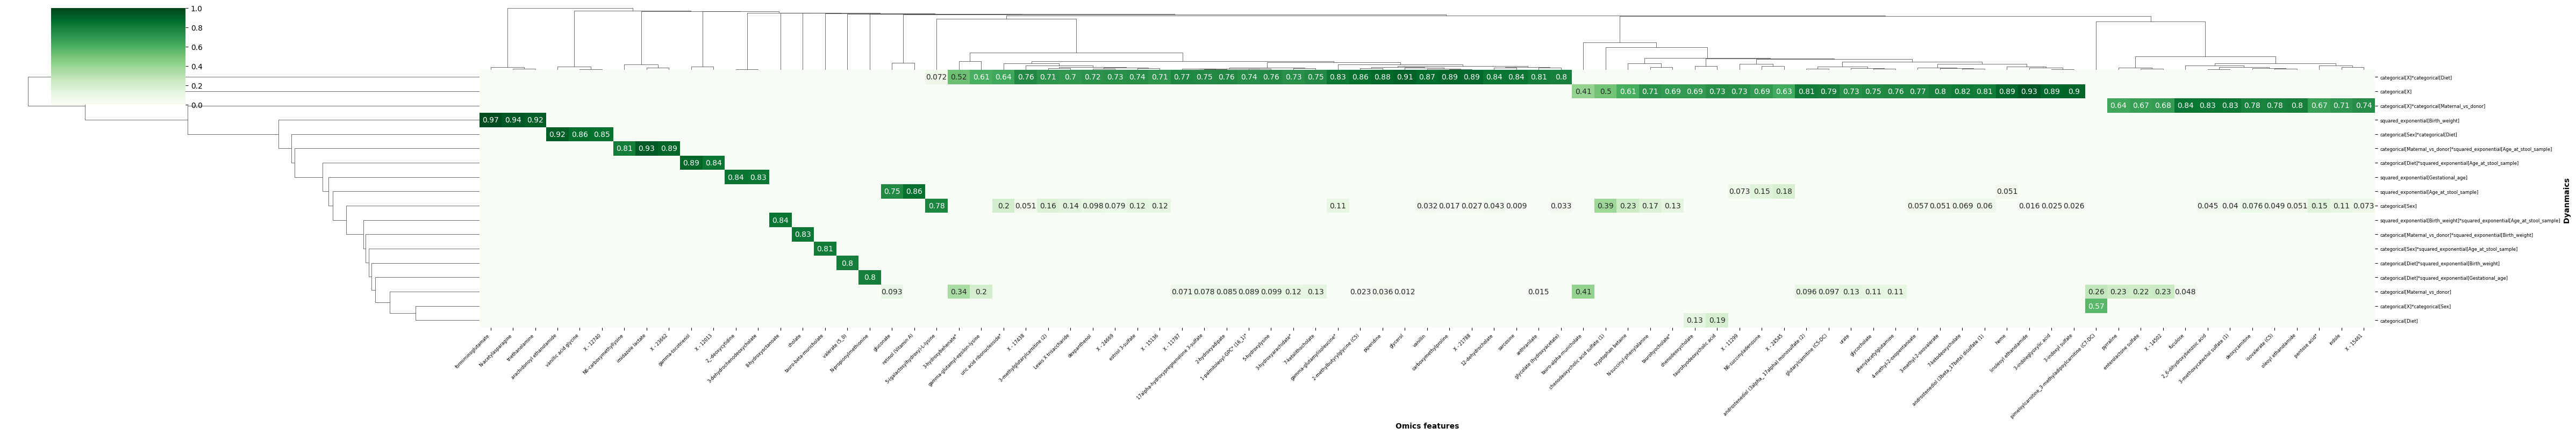

In [11]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
#plt.rcParams['figure.figsize'] = 10, 3
#plt.figure(figsize=(7.2, 3))
# Assuming `gps` is your ClusterGrid
fig = loaded_gps.plot_heatmap(var_cutoff=0.8, figsize = (50, 10))
#plt = pylab.figure(figsize=(3, 2.5))
#plt.figure(figsize=(7.2, 3))
# Access the heatmap axes directly
ax_heatmap = fig.ax_heatmap
# Set xlabel on the heatmap axes
ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)


ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=6)# top='off', bottom='on', direction='out')
ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

plt.savefig('/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/Github example/Breastmilk/Heatmap_var_cutoff_08.svg', dpi=600, bbox_inches = "tight") 
plt.savefig('/Users/alireza/Desktop/Research/Waveome Codes/Projects/Breastmilk/Github example/Breastmilk/Heatmap_var_cutoff_08.pdf', dpi=600, bbox_inches = "tight") 
plt.show() 